# Upwelling velocities notebook

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import gsw
import cmocean
import os
from datetime import datetime
from matplotlib import gridspec
from salishsea_tools import grid_tools, tidetools, viz_tools, places, utilities

%matplotlib inline
plt.rcParams['font.size'] = 12

### Local functions

In [3]:
def make_pressure_diagram():
    """Quick plotting code for pressure diagram
    """

    # Make figure
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([0.1, 0.8])
    ax.yaxis.set_ticklabels(['$z=-h$', '$z=0$'])

    # Add lines
    x = np.arange(0, 1.01, 0.01)
    ax.plot([0, 1], [0.8, 0.8], 'k--')
    ax.plot([0, 1], [0.1, 0.1], 'k--')
    ax.plot(x, np.sin(2*np.pi*x-1.5)/6 + 0.8, 'k-')
    ax.plot(x, np.sin(2*np.pi*x-1.5)/12 + 0.1, 'k-')

    # Add labels
    ax.arrow(0.5, 0.8, 0, 0.14, head_width=0.01, fc='k')
    ax.arrow(0.5, 0.1, 0, 0.06, head_width=0.01, fc='k')
    ax.arrow(0.24, 0.1, 0, 0.68, head_width=0.01, fc='k')
    ax.arrow(0.48, 0.19, 0, 0.75, head_width=0.01, fc='k')
    ax.text(0.505, 0.86, '$\eta$')
    ax.text(0.505, 0.12, '$\\xi$')
    ax.text(0.245, 0.5, '$\sum_k^0e3t(0)$')
    ax.text(0.485, 0.5, '$\sum_k^0e3t(t)$')

    plt.show()
    
    return

### Prepare results

Load run files

In [4]:
# Load run files
results_path = '/data/vdo/MEOPAR/completed-runs/stats-runs2/25apr15'
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
TRC = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150425_20150429_ptrc_T.nc'))
T = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150425_20150429_grid_T.nc'))
U = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150425_20150429_grid_U.nc'))
V = xr.open_dataset(os.path.join(results_path, 'SalishSea_1h_20150425_20150429_grid_V.nc'))
GEM = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
GEM = GEM.sel(time=slice('2015 Apr 25', '2015 Apr 29'))

Define slices and parameters

In [5]:
# Gravitational acceleration
g = 9.81
f = 1e-4

# Define slices
trange = [10, 100]
xrange = [115, 220]
yrange = [500, 675]
idepth = 22
tslice = slice(*trange)
xslice = slice(*xrange)
yslice = slice(*yrange)

# Define dims
x = mask.x[xslice].values
y = mask.y[yslice].values

# Define parameters
e3t_0 = mask.e3t_0[..., yslice, xslice].values
gdept_0 = mask.gdept_0[..., yslice, xslice].values
tmask = mask.tmask[0, :, yslice, xslice].values
eta = T.sossheig[tslice, yslice, xslice].values

# Upwelling tracer field
tracer = TRC.mytracer3[tslice, 0, yslice, xslice]
GEM = GEM.isel(time=tslice)

Extract the model velocity field

In [6]:
# Extract and unstagger the model velocity fields
u = U.vozocrtx[tslice, idepth, yslice, xslice].values
v = V.vomecrty[tslice, idepth, yslice, xslice].values
u[:, 1:, 1:], v[:, 1:, 1:] = viz_tools.unstagger(u, v)

Calculate time-dependent vertical grid, $\rho$, and $\rho=1022$ kg m$^{-3}$ surface

In [7]:
# Obtain the time dependent grid parameters
VVL = grid_tools.calculate_time_dependent_grid(e3t_0[0, ...], tmask, eta, {'e3t_t': e3t_0, 'gdept_t': gdept_0})

# Calculate rho
rho = gsw.rho(T.vosaline[tslice, :, yslice, xslice], T.votemper[tslice, :, yslice, xslice], VVL['gdept_t'])

# Calculate 1022 surface depth
index = abs(rho - 1022).argmin(axis=1)
p, _, m, n = VVL['gdept_t'].shape
depth_1022 = np.zeros((p, m, n))
for t in range(p):
    for j in range(m):
        for i in range(n):
            depth_1022[t, j, i] = VVL['gdept_t'][t, index[t, j, i], j, i]

### Calculate the total pressure field

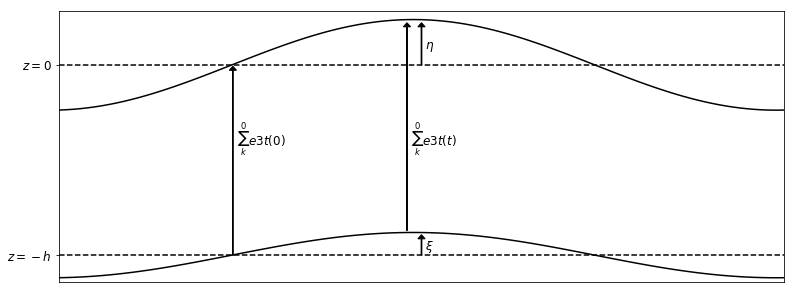

In [8]:
make_pressure_diagram()

$$\xi = \eta - \left(\sum_k^0e3t(t) - \sum_k^0e3t(0)\right)$$

$$p = g\int_{-h}^\eta\rho dz = g\int_{-h+\xi}^\eta\rho dz + g\rho_{deep}\xi$$

In [9]:
# Calculate z surface displacement xi
stretching = VVL['e3t_t'][:, :idepth, ...].sum(axis=1) - e3t_0[:, :idepth, ...].sum(axis=1)
xi = eta - stretching

# Define rho at z surface
rho_bot = rho[:, idepth, ...]
rho_bot[xi < 0] = rho[:, idepth - 1, ...][xi < 0]

# Calculate pressure
pressure = g * ((rho[:, :idepth, ...] * VVL['e3t_t'][:, :idepth, ...]).sum(axis=1) + rho_bot * xi)

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less


### Calculate geostrophic and ageostrophic velocities

$$
\begin{align}
u & = -\frac{1}{f\rho}\frac{\partial p}{\partial y} \\
v & = \frac{1}{f\rho}\frac{\partial p}{\partial x}
\end{align}
$$

$$\mathbf{u}_a = \mathbf{u} - \mathbf{u}_g$$

In [10]:
# Calculate the pressure gradient
dpdy, dpdx = np.gradient(pressure, axis=(1, 2))

# Calculate the geostrophic velocities
u_g = -1 / (f * rho[:, idepth, ...]) * dpdy / mask.e2t[:, yslice, xslice].values
v_g = 1 / (f * rho[:, idepth, ...]) * dpdx / mask.e1t[:, yslice, xslice].values

# Calculate ageostrophic velocities
u_a = u - u_g
v_a = v - v_g

In [41]:
# Filter tides
u_filt = tidetools.filter_timeseries(u)
v_filt = tidetools.filter_timeseries(v)
u_g_filt = tidetools.filter_timeseries(u_g)
v_g_filt = tidetools.filter_timeseries(v_g)
u_a_filt = tidetools.filter_timeseries(u_a)
v_a_filt = tidetools.filter_timeseries(v_a)
eta_filt = tidetools.filter_timeseries(eta)
depth_1022_filt = tidetools.filter_timeseries(depth_1022)
pressure_filt = tidetools.filter_timeseries(pressure)

Now let's take a look

In [145]:
def plotit(t):
    """
    """
    
    # Plot parameters
    trange_plot = [0, 90]
    tslice_plot = slice(*trange_plot)
    j, i = places.PLACES['Sisters Islet']['GEM2.5 grid ji']
    j_NEMO, i_NEMO = places.PLACES['Sisters Islet']['NEMO grid ji']
    index = GEM.v_wind[tslice_plot, j, i].values > 0
    depth_1022_plot = np.ma.masked_where(depth_1022_filt > 100, depth_1022_filt)

    # Make plot grid
    axs = []
    fig = plt.figure(figsize=(14, 17))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 5, 5])
    axs.append(fig.add_subplot(gs[0, :]))
    axs.extend([fig.add_subplot(gs[1, col]) for col in range(3)])
    axs.extend([fig.add_subplot(gs[2, col]) for col in range(3)])
    cax_eta = fig.add_axes([0.35, 0.47, 0.008, 0.3])
    cax_pyc = fig.add_axes([0.62, 0.47, 0.008, 0.3])
    cax_prs = fig.add_axes([0.9, 0.47, 0.008, 0.3])

    # Plot wind record
    axs[0].fill_between(GEM.time.values[tslice_plot], GEM.v_wind[tslice_plot, j, i].values, where=index, color='firebrick', interpolate=True)
    axs[0].fill_between(GEM.time.values[tslice_plot], GEM.v_wind[tslice_plot, j, i].values, where=~index, color='darkslategray', interpolate=True)
    axs[0].plot(GEM.time.values[tslice_plot], GEM.v_wind[tslice_plot, j, i].values, 'k-')
    axs[0].plot([GEM.time.values[t], GEM.time.values[t]], [-12, 12], 'k-')
    axs[0].set_xlim([GEM.time.values[trange_plot[0]], GEM.time.values[trange_plot[1]-1]])
    axs[0].set_ylim([-12, 12])
    axs[0].set_title('Alongstrait windspeed at Sisters Islet')
    axs[0].set_ylabel('m/s')

    # Plot pressure fields
    c_eta = axs[1].contourf(x, y, eta_filt[t, ...], levels=np.arange(-0.11, 0, 0.005), cmap=cmocean.cm.deep, extend='both')
    c_pyc = axs[2].contourf(x, y, depth_1022_plot[t, ...], levels=np.arange(0, 31, 2), cmap=cmocean.cm.turbid, extend='both')
    c_prs = axs[3].contourf(x, y, pressure_filt[t, ...]*1e-4, levels=np.arange(30.97, 30.99, 0.001), cmap=cmocean.cm.dense, extend='both')
    fig.colorbar(c_eta, cax=cax_eta, label='m above zero')
    fig.colorbar(c_pyc, cax=cax_pyc, label='m below surface')
    fig.colorbar(c_prs, cax=cax_prs, label='dbar')
    
    # Plot velocity fields
    q = axs[4].quiver(x[::5], y[::5], u_filt[t, ::5, ::5], v_filt[t, ::5, ::5], scale=1, width=0.005)
    index = (abs(u_g_filt[t, ::5, ::5]) > 0.5) | (abs(v_g_filt[t, ::5, ::5]) > 0.5)
    axs[5].quiver(
        x[::5], y[::5],
        np.ma.masked_where(index, u_g_filt[t, ::5, ::5]),
        np.ma.masked_where(index, v_g_filt[t, ::5, ::5]),
        scale=1, width=0.005,
    )
    index = (abs(u_a_filt[t, ::5, ::5]) > 0.5) | (abs(v_a_filt[t, ::5, ::5]) > 0.5)
    axs[6].quiver(
        x[::5], y[::5],
        np.ma.masked_where(index, u_a_filt[t, ::5, ::5]),
        np.ma.masked_where(index, v_a_filt[t, ::5, ::5]),
        scale=0.5, width=0.005,
    )
    plt.quiverkey(q, 0.2, 0.05, 0.1, '0.1 m/s')

    # Add coastline and format
    titles = [
        '$\eta$', '$h_{\sigma=22}$', '$p_{\mathrm{30 m}}$',
        '$\mathbf{u}_{\mathrm{30 m}}$', '$\mathbf{u}_{g\mathrm{30 m}}$', '$\mathbf{u}_{a\mathrm{30 m}}$',
    ]
    axs[1].set_ylabel('Model grid y')
    axs[4].set_ylabel('Model grid y')
    axs[4].set_xlabel('Model grid x')
    axs[5].set_xlabel('Model grid x')
    axs[6].set_xlabel('Model grid x')
    axs[2].yaxis.set_ticklabels('')
    axs[3].yaxis.set_ticklabels('')
    axs[5].yaxis.set_ticklabels('')
    axs[6].yaxis.set_ticklabels('')
    axs[1].xaxis.set_ticklabels('')
    axs[2].xaxis.set_ticklabels('')
    axs[3].xaxis.set_ticklabels('')
    for ax, title in zip(axs[1:], titles):
        ax.contourf(x, y, tmask[0, ...], levels=[-0.01, 0.01], colors='Burlywood')
        ax.contour(x, y, tmask[0, ...], levels=[-0.01, 0.01], colors='k')
        ax.plot(i_NEMO, j_NEMO, 'ro', markeredgecolor='k', linewidth=2, markersize=10)
        ax.set_title(title)
        viz_tools.set_aspect(ax)
    
    return

/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: invalid value encountered in greater


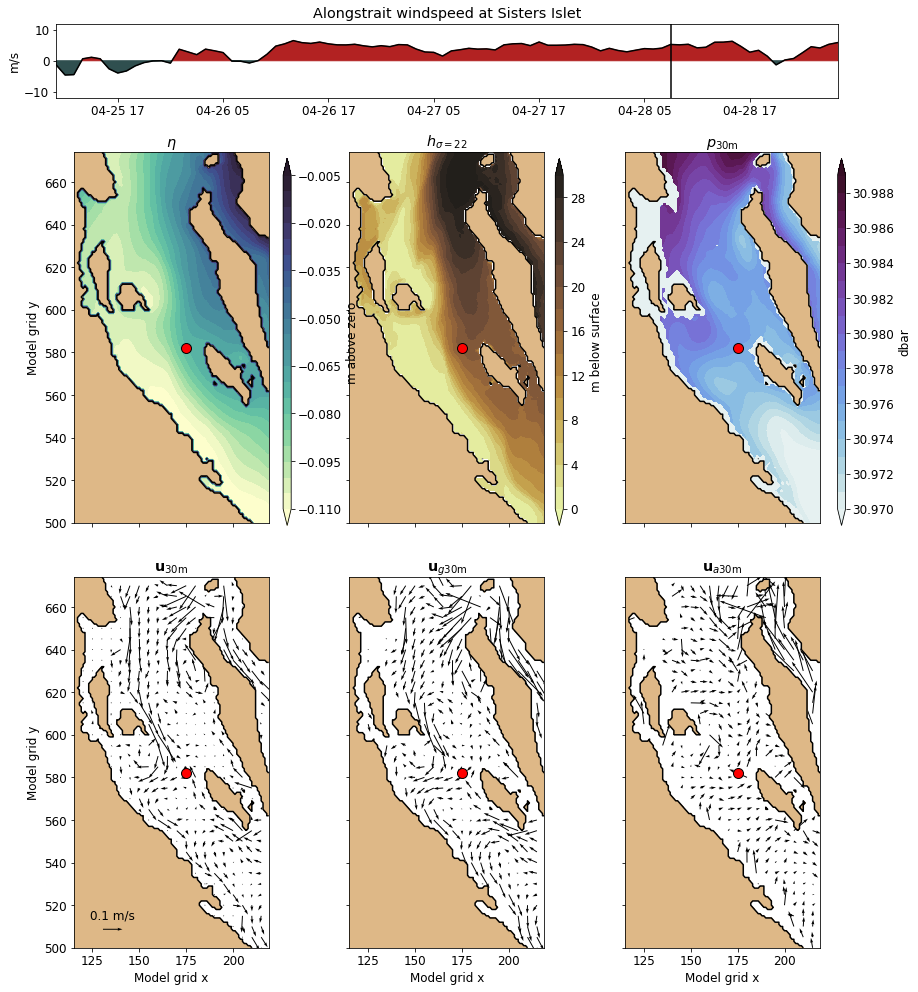

In [146]:
plotit(70)